## Read first 10000 rows from json file

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json
import pandas as pd
def read_json_nrows(nrows,filename):
    n= 0
    with open(filename) as f:
        while n < nrows:
            if n == 0:
                line = f.readline()
                line = json.loads(line.rstrip())
                train = pd.DataFrame(line,index = [0])
            else:
                temp = pd.DataFrame(json.loads(f.readline().rstrip()),index = [n])
                train = train.append(temp)
            n = n+1
    return train

In [3]:
train_10000 = read_json_nrows(10000,'review_train.json')

In [4]:
train_10000.head(5)

,business_id,stars,text,date
0,31292,1.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,35344,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,152538,5.0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,71871,5.0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,64913,1.0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


## Cleaning data

In [5]:
from collections import Counter
from nltk.util import ngrams
import re
import numpy as np 
from nltk.corpus import words
from nltk.corpus import brown
from nltk.corpus import wordnet
from nltk import wordpunct_tokenize

### Languages

When I first tried to apply the *detect* function I got a 'No features in text' error. So I have to find out which review is empty.

In [6]:
train_10000.loc[6687]

business_id                 137207
stars                            1
text                            :(
date           2017-07-18 20:31:03
Name: 6687, dtype: object

This review is not language, but an emoticon.

In [7]:
def not_language(text):
    # First delete all common emoticons.
    text = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)','',text)
    if re.sub('[\W]+','',text) == '':
        return True
    else:
        return False

For simplicity, just consider emoticons as English.

In [8]:
not_lang = train_10000[train_10000.text.apply(not_language)].index.values

In [9]:
train_10000.loc[not_lang,'lang_type'] = 'english'

from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
languages_ratios = {}
for i in range(10000):
    tokens = wordpunct_tokenize(train_10000.text[i])
    words = [word.lower() for word in tokens]
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)
        languages_ratios[language] = len(common_elements)
    most_rated_language = max(languages_ratios, key=languages_ratios.get)
    train_10000.loc[i,'lang_type'] = most_rated_language

In [10]:
from langdetect import detect
for i in range(10000):
    if i in not_lang:
        continue
    else:
        train_10000.loc[i,'lang_type'] = detect(train_10000.text[i])

In [12]:
train_10000.lang_type.value_counts()

en         9957
fr           37
es            3
ja            1
de            1
english       1
Name: lang_type, dtype: int64

Focus on English only at present.

In [13]:
train_10000_eng = train_10000[train_10000.lang_type == 'en']

Most common words and phrases.

In [14]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 1)]
Counter(text_trigrams).most_common(20)

[(('the',), 43484),
 (('and',), 36445),
 (('I',), 27219),
 (('a',), 26196),
 (('to',), 25807),
 (('was',), 18766),
 (('of',), 15249),
 (('is',), 12815),
 (('for',), 12221),
 (('in',), 11026),
 (('it',), 9188),
 (('The',), 9181),
 (('with',), 8640),
 (('my',), 8424),
 (('that',), 8146),
 (('but',), 7072),
 (('on',), 7003),
 (('have',), 6583),
 (('you',), 6540),
 (('this',), 6388)]

In [15]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 2)]
Counter(text_trigrams).most_common(20)

[(('of', 'the'), 3443),
 (('and', 'the'), 2772),
 (('in', 'the'), 2722),
 (('it', 'was'), 2336),
 (('I', 'was'), 2307),
 (('on', 'the'), 2107),
 (('and', 'I'), 2017),
 (('to', 'the'), 1836),
 (('for', 'the'), 1732),
 (('for', 'a'), 1732),
 (('I', 'had'), 1559),
 (('I', 'have'), 1490),
 (('is', 'a'), 1378),
 (('to', 'be'), 1358),
 (('was', 'a'), 1313),
 (('this', 'place'), 1278),
 (('with', 'the'), 1262),
 (('at', 'the'), 1245),
 (('with', 'a'), 1216),
 (('to', 'get'), 1206)]

In [16]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
Counter(text_trigrams).most_common(20)

[(('and', 'it', 'was'), 516),
 (('one', 'of', 'the'), 451),
 (('a', 'lot', 'of'), 392),
 (('I', 'had', 'the'), 338),
 (('This', 'place', 'is'), 316),
 (('I', 'have', 'been'), 265),
 (('I', 'had', 'to'), 262),
 (('the', 'food', 'was'), 254),
 (('I', 'ordered', 'the'), 247),
 (('it', 'was', 'a'), 244),
 (('of', 'the', 'best'), 239),
 (('The', 'food', 'was'), 237),
 (('I', 'had', 'a'), 236),
 (('some', 'of', 'the'), 206),
 (('The', 'food', 'is'), 199),
 (('this', 'place', 'is'), 198),
 (('The', 'service', 'was'), 187),
 (('the', 'food', 'is'), 187),
 (('to', 'get', 'a'), 182),
 (('This', 'is', 'a'), 181)]

In [17]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 4)]
Counter(text_trigrams).most_common(20)

[(('one', 'of', 'the', 'best'), 126),
 (('My', 'husband', 'and', 'I'), 88),
 (('I', 'will', 'definitely', 'be'), 77),
 (('is', 'one', 'of', 'the'), 73),
 (('the', 'end', 'of', 'the'), 67),
 (('in', 'the', 'middle', 'of'), 65),
 (('for', 'the', 'first', 'time'), 65),
 (('a', 'great', 'place', 'to'), 62),
 (('some', 'of', 'the', 'best'), 60),
 (('and', 'the', 'service', 'was'), 56),
 (('you', 'are', 'looking', 'for'), 55),
 (('was', 'one', 'of', 'the'), 54),
 (('and', 'the', 'food', 'was'), 53),
 (('I', 'have', 'to', 'say'), 52),
 (('My', 'wife', 'and', 'I'), 50),
 (('and', 'the', 'food', 'is'), 50),
 (('was', 'my', 'first', 'time'), 49),
 (('one', 'of', 'my', 'favorite'), 49),
 (('the', 'rest', 'of', 'the'), 48),
 (('I', "can't", 'wait', 'to'), 47)]

Oddest words

In [18]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 1)]
Counter(text_trigrams).most_common()[-500:]

[(('qualified,',), 1),
 (('exuded',), 1),
 (("'cool'",), 1),
 (('Danny.',), 1),
 (('accord',), 1),
 (('b-day.',), 1),
 (('Terroni.',), 1),
 (('raptor',), 1),
 (('flats',), 1),
 (('gripe...no',), 1),
 (('GPS?',), 1),
 (('yardage',), 1),
 (('caliber,',), 1),
 (('troon',), 1),
 (('Quintero',), 1),
 (('parking....my',), 1),
 (('pefect',), 1),
 (('Dewy',), 1),
 (('appoinment,',), 1),
 (('in...)',), 1),
 (('HVAC/Electrical/etc...',), 1),
 (('electrical....(I',), 1),
 (('NHW',), 1),
 (('compressor',), 1),
 (('verified',), 1),
 (('TUESDAY',), 1),
 (('compressor....',), 1),
 (('occasions....',), 1),
 (('SH!*',), 1),
 (('Moe',), 1),
 (('matted',), 1),
 (('Choosing',), 1),
 (('changing,',), 1),
 (('eats!',), 1),
 (('loong',), 1),
 (('lo-mean,',), 1),
 (('Discovered',), 1),
 (('Beach.',), 1),
 (('Thrilled',), 1),
 (('favs:',), 1),
 (('DELISH!)',), 1),
 (('is..',), 1),
 (('Woo',), 1),
 (('Che.',), 1),
 (('grilles,',), 1),
 (('bugogi',), 1),
 (('thicker,',), 1),
 (('Louie,',), 1),
 (('hmmm,',), 1),


Here I found two sentences in Chinese:
- (('不要在这里吃！',), 1),
- (('我们刚在这里吃午饭，在我们的汤里发现了一个蟑螂，我把它展示给服务员，她说：哦，对不起。你不必付饭费"，这意味着他们的厨房里有很多蟑螂，他们知道，她一点都不惊讶。',),  

Most of these rare words have some punctuations.

In [19]:
text = ' '.join(train_10000_eng.text.values)
text_trigrams = [i for i in ngrams(text.split(), 2)]
Counter(text_trigrams).most_common()[-20:]

[(('visit!', "Haven't"), 1),
 (('years', 'bc'), 1),
 (('something', 'drew'), 1),
 (('whites', 'mixed'), 1),
 (('with', 'bellpeppers,'), 1),
 (('bellpeppers,', 'onions'), 1),
 (('tomatoes,', 'avocado'), 1),
 (('fruit,', 'with'), 1),
 (('muffin.', 'Super'), 1),
 (('Super', 'healthy'), 1),
 (('with', 'Pam'), 1),
 (('Pam', 'instead'), 1),
 (('they', 'willingly'), 1),
 (('willingly', 'accommodated!'), 1),
 (('accommodated!', 'This'), 1),
 (('server', '(Matt!)'), 1),
 (('(Matt!)', 'was'), 1),
 (('AWESOME!', 'Come'), 1),
 (('and', 'visit--worth'), 1),
 (('visit--worth', 'it!'), 1)]

### Check bad words

#### First emoticons

In [20]:
def find_emoticons(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    if emoticons == []:
        return False
    else:
        return True

In [21]:
eg1 = np.where(train_10000_eng.text.apply(find_emoticons) == True)[0][0]

In [22]:
train_10000_eng.iloc[eg1].text

"Man, I love Toronto! Hiding in a strip mall on Overlea, find a dingy looking restaurant that serves up fantastic, cheap kabob...be warned regardless of when you come here you'll likely be waiting for a table as this place is always overrun with people...If you're a fan of perfectly grilled spicy meat, you must try this place out...now that I've been here I need to limit how many times I go here per month :)\n\nTake the drive out and have some kabob...if you don't own a car, borrow one or get a zipcar membership...totally worth it!"

Here we can find one  :)  together with two '\n' 

In [23]:
re.sub('\\n','',train_10000_eng.iloc[eg1].text)

"Man, I love Toronto! Hiding in a strip mall on Overlea, find a dingy looking restaurant that serves up fantastic, cheap kabob...be warned regardless of when you come here you'll likely be waiting for a table as this place is always overrun with people...If you're a fan of perfectly grilled spicy meat, you must try this place out...now that I've been here I need to limit how many times I go here per month :)Take the drive out and have some kabob...if you don't own a car, borrow one or get a zipcar membership...totally worth it!"

#### Check typos

In [24]:
# Most packages can't handle some words like 'nooooo'. 
def check_same(word):
    intervals = {}
    for index,letter in enumerate(word):
        if letter == word[index-1]:
            if letter in intervals.keys():
                interval = intervals.pop(letter)
                lastguy = interval[len(interval)-1] 
                if lastguy[1] == (index-1):
                    lastguy = (lastguy[0],index)
                    interval[len(interval)-1] = lastguy
                    intervals[letter] = interval
                else:
                    lastguy1 = (index-1,index)
                    interval.append(lastguy1)
                    intervals[letter] = interval
            else:
                intervals[letter] = [(index-1,index)]
    return intervals

In [25]:
# I have never seen a word with three continuous same letter, so I will delete till two.
def no_more_than_2(word,dupli):
    for key in dupli.keys():
        for interval in dupli[key]:
            length = interval[1]-interval[0]+1
            regex = '(%s'%key + '{%i})'%length
            word = re.sub(regex,key+key,word)
    return word

In [26]:
from pattern.en import suggest
from itertools import combinations
def right_spelling(word,dupli):
    key_list = []
    for key in dupli.keys():
        key_list.append(key)
    n = len(key_list)
    for i in range(n):
        for comb in combinations(key_list,i):
            for letter in comb:
                regex = '(%s'%letter + '{2})'
                new_word = re.sub(regex,letter,word)
                if new_word in brown.words():
                    return new_word
    return suggest(word)[0][0]

In [27]:
def no_typo(word):
    if len(word) == len(set(word)):
        return word
    if suggest(word)[0][1] == 1:
        return suggest(word)[0][0]
    else:
        duplicates = check_same(word)
        two = no_more_than_2(word,duplicates)
        suggest_two = suggest(two)
        if suggest_two[0][1] == 1:
            return suggest_two[0][0]
        else:
            return right_spelling(two,duplicates)
        
        return right_spelling(word)

In [28]:
no_typo('finaaallly')

'finally'

#### Lemmatization

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

In [30]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [31]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
wnl = WordNetLemmatizer()
def lemmatizer(text):
    tokens = word_tokenize(text)
    
    lemmas = []
    tags = []
    tagged = pos_tag(tokens)
    for tag in tagged:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        if tag[0] not in preposition:
            lemmas.append(wnl.lemmatize(tag[0], pos=wordnet_pos))
            tags.append(wordnet_pos)
        else:
            lemmas.append(tag[0])
            tags.append('p')
    return {'lemmas':lemmas, 'tags':tags}

#### Stop-words

I think words which mean negative are important.

In [32]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.pop(stop.index('but'))
stop.pop(stop.index('not'))

'not'

In [33]:
preposition = ['of','with','at','from','into','during',
               'including','until','till','against','among',
               'throughout','despite','towards','upon','concerning','to','in',
               'for','on','by','about','like','through','over',
               'before','between','after','since','without','under',
               'within','along','following','across','behind',
               'beyond','plus','except','but','up','out','around','down','off','above','near']
for prep in preposition:
    if prep in stop:
        stop.pop(stop.index(prep))

In [34]:
lemmatizer('He is one of my friend')

{'lemmas': ['He', 'be', 'one', 'of', 'my', 'friend'],
 'tags': ['n', 'v', 'n', 'p', 'n', 'n']}

#### Convert n't to not

In [35]:
def no_abbreviation(text):
    text = re.sub('n\'t',' not',text)
    return text

#### Adversatives

In [36]:
but = ['yet','however','nonetheless','whereas','nevertheless']
although = ['although','though','notwithstanding','albeit']

In [37]:
def change_but(text):
    for x in but:
        text = re.sub(x,'but',text)
    return text
def change_although(text):
    for x in although:
        text = re.sub(x,'although',text)
    return text
def change_adversatives(text):
    text = change_but(text)
    text = change_although(text)
    return text

In [38]:
def preprocessing(text):

    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)

    text = re.sub('\\n',' ',text)

    text = no_abbreviation(text)

    text = re.sub('[\W]+',' ', text.lower())

    text = change_adversatives(text)

    lemma = lemmatizer(text)
    tokens = lemma['lemmas']
    tags = lemma['tags']
    
    text = ''
    tag = []
    for index, token in enumerate(tokens):

        #tokens[index] = no_typo(token)
        if token in stop:
            continue
        else:
            text = text + tokens[index] + ' '
            tag.append(tags[index])
    return {'text':text,'emoticons':emoticons,'tags':tag}

In [39]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()
dictionary = train_10000_eng.text.progress_apply(preprocessing)

100%|██████████| 9957/9957 [00:54<00:00, 183.93it/s]


In [40]:
emoticons = [dictionary[i]['emoticons'] for i in train_10000_eng.index]

In [41]:
texts = [dictionary[i]['text'] for i in train_10000_eng.index]

In [42]:
tags = [dictionary[i]['tags'] for i in train_10000_eng.index]

#### Phrases

In [43]:
from gensim.models.phrases import Phrases, Phraser
sentence_stream = [sent.split(' ') for sent in texts]
phrases = Phrases(sentence_stream, min_count=5, threshold=5)
bigram = Phraser(phrases)

#### Most Frequent Words

In [44]:
sentence_with_phrase = bigram[sentence_stream]

In [45]:
texts_with_phrases = np.array([x for x in sentence_with_phrase])

In [46]:
sentences_with_phrases = np.empty_like(texts_with_phrases)
for index,x in enumerate(texts_with_phrases):
    z = ''
    for y in x:
        z = z + y + ' '
    sentences_with_phrases[index] = z

In [47]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in sentence_with_phrase:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

23748

In [48]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['to', 'not', 'for', 'of', 'but', 'in', 'with', 'get', 'on', 'place']

#### Word cloud

In [49]:
from wordcloud import WordCloud

In [50]:
one = sentences_with_phrases[np.where(train_10000_eng.stars == 1.0)[0]]
two = sentences_with_phrases[np.where(train_10000_eng.stars == 2.0)[0]]
three = sentences_with_phrases[np.where(train_10000_eng.stars == 3.0)[0]]
four = sentences_with_phrases[np.where(train_10000_eng.stars == 4.0)[0]]
five = sentences_with_phrases[np.where(train_10000_eng.stars == 5.0)[0]]

In [51]:
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

#####  1-star

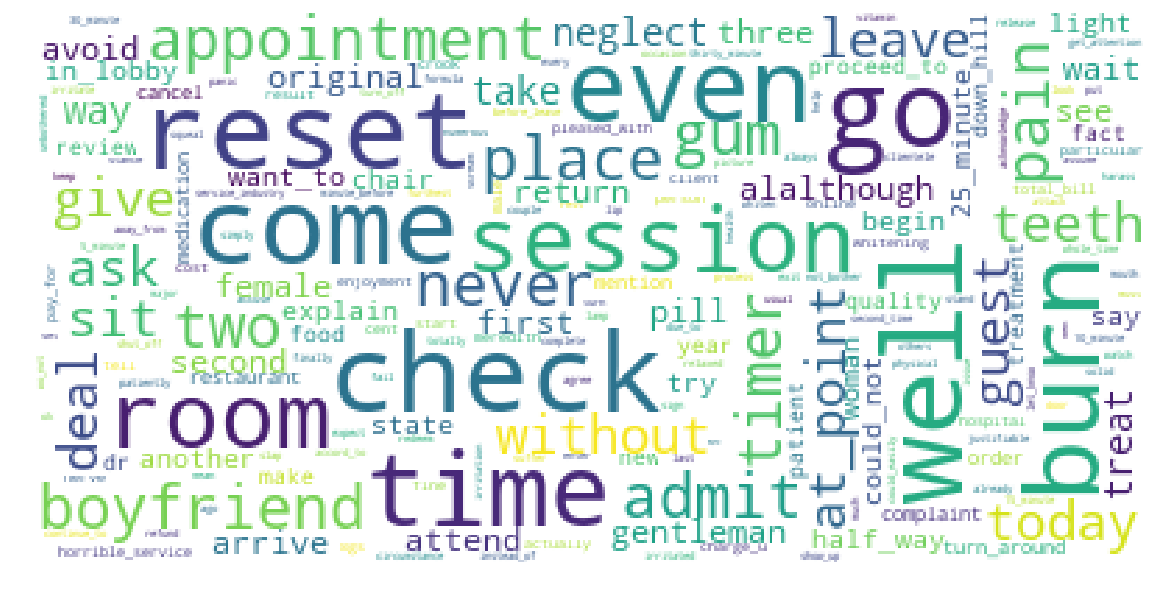

In [52]:
wordcloud_1 = WordCloud(
                          background_color='white',
                          stopwords=None,
                          max_words=200,
                          max_font_size=40, 
                         ).generate(str(one))
cloud_plot(wordcloud_1)


In [53]:
words1 = wordcloud_1.words_

##### 2-star

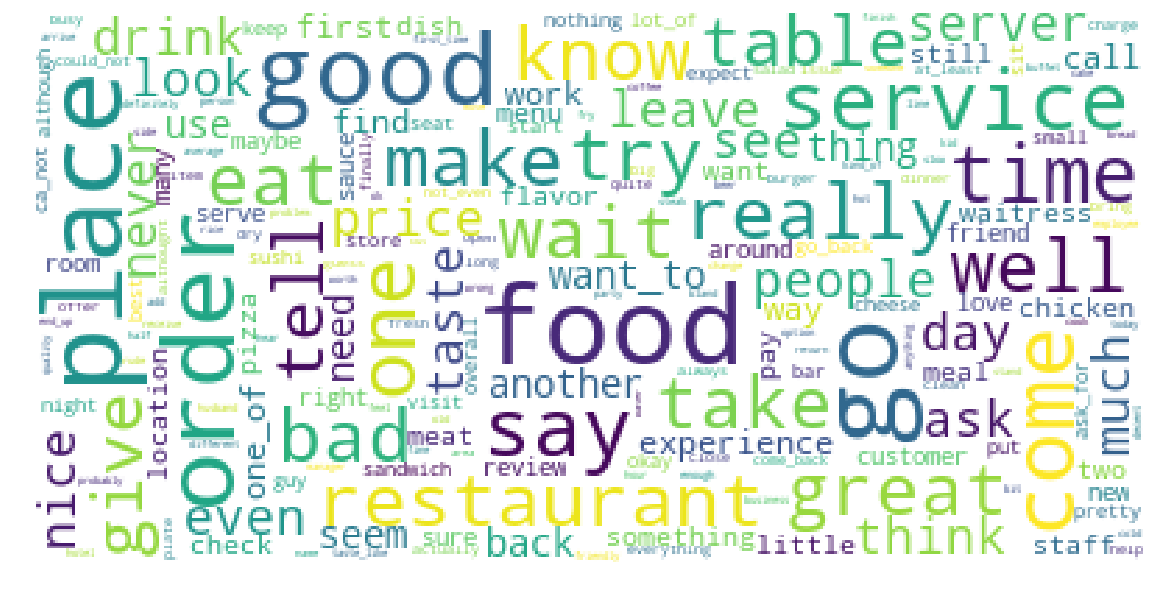

In [54]:
wordcloud_2 = WordCloud(
                          background_color='white',
                          stopwords=None,
                          max_words=200,
                          max_font_size=40, 
                         ).generate(str(two))
cloud_plot(wordcloud_2)


In [55]:
words2 = wordcloud_2.words_

##### 3-star

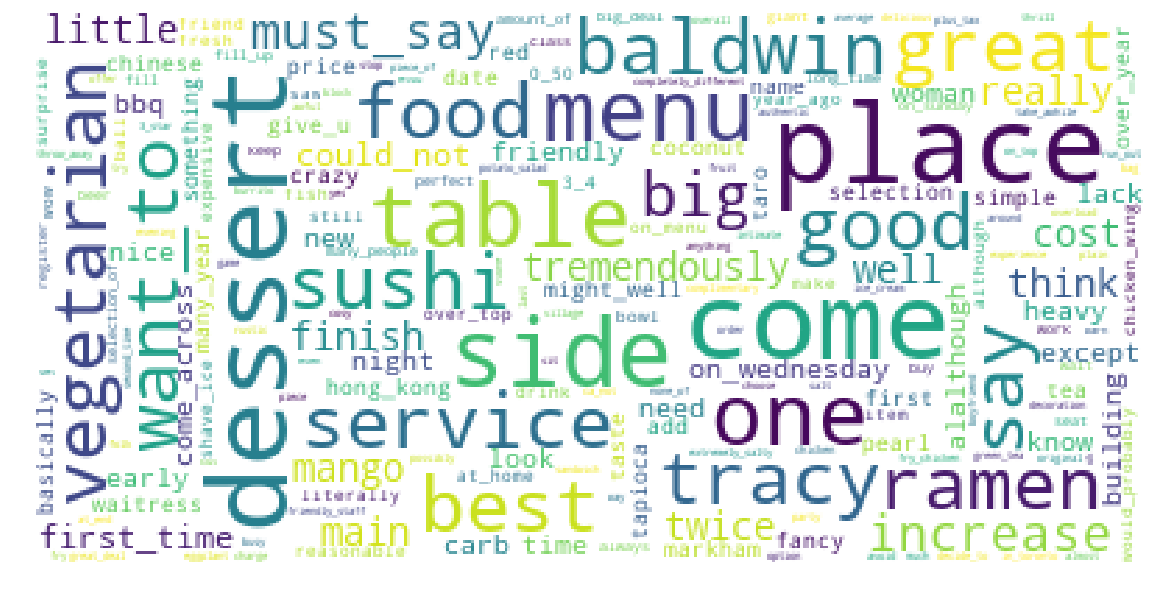

In [56]:
wordcloud_3 = WordCloud(
                          background_color='white',
                          stopwords=None,
                          max_words=200,
                          max_font_size=40, 
                         ).generate(str(three))
cloud_plot(wordcloud_3)


In [57]:
words3 = wordcloud_3.words_

##### 4-star

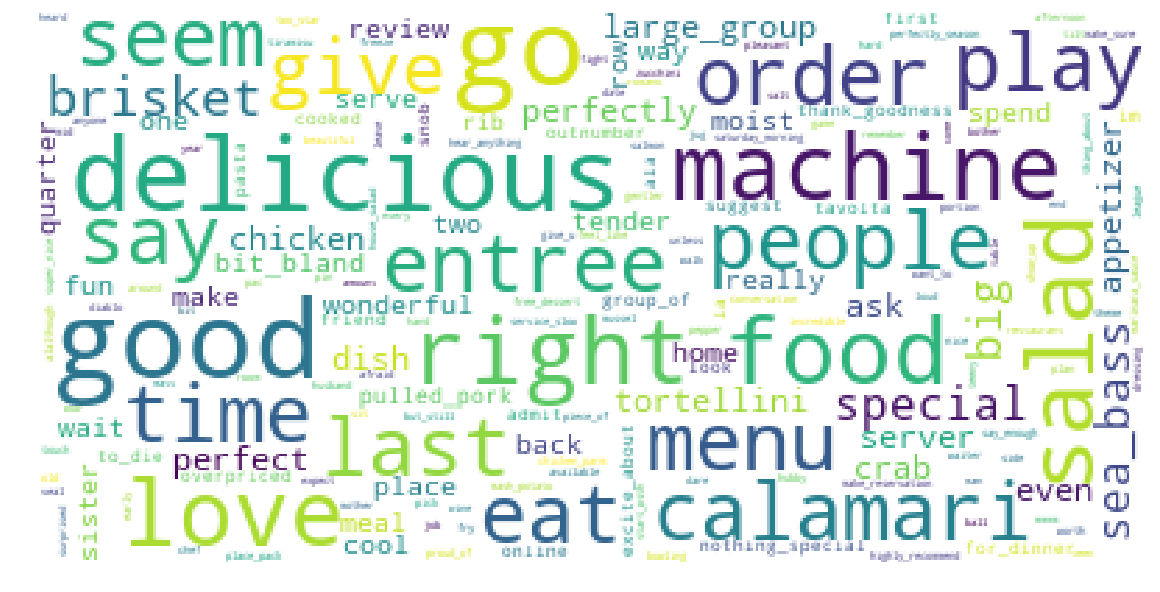

In [58]:
wordcloud_4 = WordCloud(
                          background_color='white',
                          stopwords=None,
                          max_words=200,
                          max_font_size=40, 
                         ).generate(str(four))
cloud_plot(wordcloud_4)


In [59]:
words4 = wordcloud_4.words_

##### 5-star

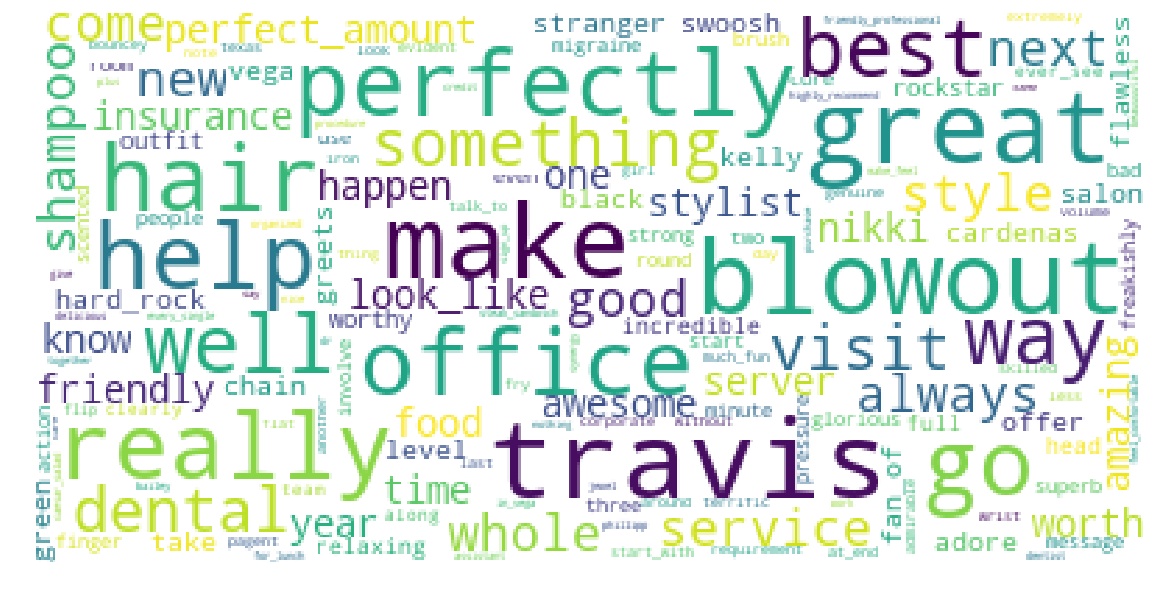

In [60]:
wordcloud_5 = WordCloud(
                          background_color='white',
                          stopwords=None,
                          max_words=200,
                          max_font_size=40, 
                         ).generate(str(five))
cloud_plot(wordcloud_5)


In [61]:
words5 = wordcloud_5.words_

In [62]:
key1 = [x for x in words1.keys()]
key2 = [x for x in words2.keys()]
key3 = [x for x in words3.keys()]
key4 = [x for x in words4.keys()]
key5 = [x for x in words5.keys()]

In [63]:
useless = set(key1).intersection(key2).intersection(key3).intersection(key4).intersection(key5)

In [64]:
useless_words = np.array([x for x in useless])

In [101]:
useless_words = np.append(useless_words,'im')

In [102]:
useless_words

array(['come', 'time', 'place', 'even', 'food', 'make', 'look', 'way',
       'say', 'im'], dtype='<U5')

In [66]:
type(sentence_with_phrase[0])

list

In [68]:
final_sentence = np.empty_like(sentence_with_phrase)
for index,sentence in enumerate(sentence_with_phrase):
    for word in sentence:
        if word in useless_words:
            sentence.pop(sentence.index(word))
    final_sentence[index] = sentence

In [89]:
final_sentence[0]

['total_bill',
 'for',
 'horrible_service',
 'over',
 '8gs',
 'crook',
 'actually',
 'nerve',
 'to',
 'charge_u',
 '69',
 'for',
 '3',
 'pill',
 'check',
 'online',
 'pill',
 'for',
 '19',
 'cent',
 'avoid',
 'hospital',
 'er',
 'at',
 'cost']

In [93]:
for index,sentence in enumerate(final_sentence):
    if 'travis' in sentence:
        print(index)

1
1365
2948
4068
7535
9016


In [98]:
train_10000_eng.iloc[[1,1365,2948,4068,7535,9016]].text.values

array(["I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.  Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure.  That was superb!  Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen.  The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement.  It wa

In [96]:
train_10000_eng.iloc[[1,1365,2948,4068,7535,9016]].business_id.values

array([ 35344, 150946, 150946,  49924, 182880, 188661])

#### word2vec

In [73]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [74]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=3,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed = 123,
                     sg=1) # sg默认为0，对应CBOW算法；sg=1则采用skip-gram算法

In [75]:
import time

t = time.clock()

w2v_model.build_vocab(sentence_with_phrase, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.clock() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [76]:
t = time.clock()

w2v_model.train(sentence_with_phrase, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.clock() - t) / 60, 2)))

Time to train the model: 2.44 mins


In [77]:
w2v_model.wv.most_similar(positive=["awesome"])

[('great', 0.8078628778457642),
 ('amaze', 0.7542029619216919),
 ('amazing', 0.716866135597229),
 ('love', 0.7116175889968872),
 ('good', 0.6958260536193848),
 ('brandi', 0.6951560974121094),
 ('fantastic', 0.6879223585128784),
 ('prompt_friendly', 0.6832953691482544),
 ('tremendous', 0.6745654344558716),
 ('friendly', 0.6743789315223694)]

#### TSNE

In [78]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 sentences' word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [w2v_model[w] for w in w2v_model.wv.vocab.keys()]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = w2v_model.wv.vocab.keys()

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

/Users/songsong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11821 samples in 0.040s...
[t-SNE] Computed neighbors for 11821 samples in 27.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11821
[t-SNE] Computed conditional probabilities for sample 2000 / 11821
[t-SNE] Computed conditional probabilities for sample 3000 / 11821
[t-SNE] Computed conditional probabilities for sample 4000 / 11821
[t-SNE] Computed conditional probabilities for sample 5000 / 11821
[t-SNE] Computed conditional probabilities for sample 6000 / 11821
[t-SNE] Computed conditional probabilities for sample 7000 / 11821
[t-SNE] Computed conditional probabilities for sample 8000 / 11821
[t-SNE] Computed conditional probabilities for sample 9000 / 11821
[t-SNE] Computed conditional probabilities for sample 10000 / 11821
[t-SNE] Computed conditional probabilities for sample 11000 / 11821
[t-SNE] Computed conditional probabilities for sample 11821 / 11821
[t-SNE] Mean sigma: 0.520164
[t-SNE] KL divergenc

#### TF-IDF

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [82]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=5,norm='l2',lowercase=False)
matrix = vectorizer.fit_transform(final_sentence)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

TypeError: expected string or bytes-like object

In [ ]:
def WordVector(tokens, size):
    vector = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vector += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: 
                continue
    if count != 0:
        vector = vector/count
    return vector